In [7]:
# Automatically re-import project-specific modules.
%load_ext autoreload
%autoreload 1

# imports
import collections
import functools
import io
import datetime
import time
import math
import itertools
import os
import shutil
import pathlib
import copy
import inspect
import random
import subprocess
import sys
import warnings
from pathlib import Path
import typing

import dipy
import dipy.core
import dipy.reconst
import dipy.reconst.dti
import dipy.segment.mask
import dotenv

# visualization libraries
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import IPython

# Try importing GPUtil for printing GPU specs.
# May not be installed if using CPU only.
try:
    import GPUtil
except ImportError:
    warnings.warn("WARNING: Package GPUtil not found, cannot print GPU specs")
from tabulate import tabulate
from IPython.display import display, Markdown

# Data management libraries.
import addict
from addict import Addict
import pprint
from pprint import pprint as ppr

# Computation & ML libraries.
import numpy as np
import pandas as pd


import skimage
import skimage.feature
import skimage.filters
import skimage.measure
import skimage.io
import scipy


# plt.rcParams.update({"figure.autolayout": True})
# plt.rcParams.update({"figure.facecolor": [1.0, 1.0, 1.0, 1.0]})
# Set print options for ndarrays/tensors.

In [8]:
# Update notebook's environment variables with direnv.
# This requires the python-dotenv package, and direnv be installed on the system
# This will not work on Windows.
# NOTE: This is kind of hacky, and not necessarily safe. Be careful...
# Libraries needed on the python side:
# - os
# - subprocess
# - io
# - dotenv

# Form command to be run in direnv's context. This command will print out
# all environment variables defined in the subprocess/sub-shell.
command = "direnv exec {} /usr/bin/env".format(os.getcwd())
# Run command in a new subprocess.
proc = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True, cwd=os.getcwd())
# Store and format the subprocess' output.
proc_out = proc.communicate()[0].strip().decode("utf-8")
# Use python-dotenv to load the environment variables by using the output of
# 'direnv exec ...' as a 'dummy' .env file.
dotenv.load_dotenv(stream=io.StringIO(proc_out), override=True);

direnv: loading ~/work/pitn/.envrc
direnv: creating conda environment

CondaValueError: prefix already exists: /opt/miniconda/envs/pitn



In [9]:
from scipy.stats import rice

In [ ]:
np

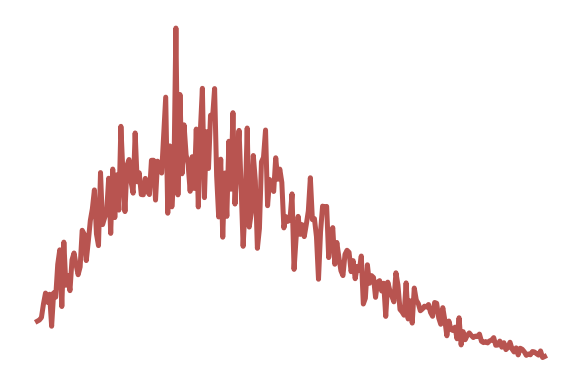

In [18]:
# Clinical Image(s) Noise Distribution
b = 0.5978
color = "#B85450"

x = np.linspace(rice.ppf(0.01, b), rice.ppf(0.99, b), 250)
noise = np.random.normal(x.mean(), x.std() / 3, size=len(x))
y = rice.pdf(x, b)
y = y * noise
with sns.plotting_context("poster"):
    plt.figure(dpi=120)
    plt.plot(x, y, color=color, lw=3)
    #     plt.ylim(-0.1, 1.5)
    #     plt.plot(-0.1, -0.1, alpha=0)
    plt.xticks([])
    plt.yticks([])
    #     plt.axvline(color='black')
    #     plt.axhline(color='black')
    plt.box(False)

clinic_b = b

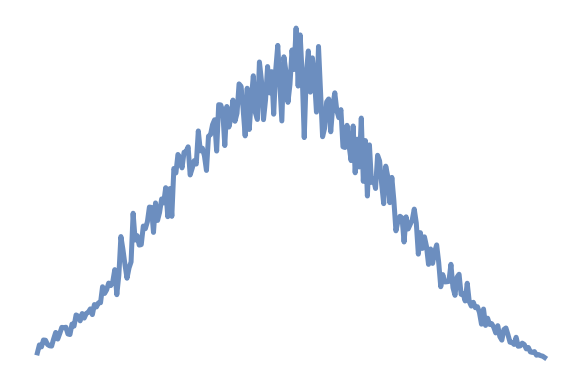

In [19]:
# HCP Images Noise Distribution
b = 2.562
color = "#6C8EBF"

x = np.linspace(rice.ppf(0.01, b), rice.ppf(0.99, b), 250)
noise = np.random.normal(x.mean(), x.std() / 5, size=len(x))
y = rice.pdf(x, b)
y = y * noise


with sns.plotting_context("poster"):
    plt.figure(dpi=120)
    plt.plot(x, y, color=color, lw=3)
    #     plt.ylim(-0.1, 1.5)
    #     plt.plot(-0.1, -0.1, alpha=0)
    plt.xticks([])
    plt.yticks([])
    #     plt.axvline(color='black')
    #     plt.axhline(color='black')
    plt.box(False)

hcp_b = b

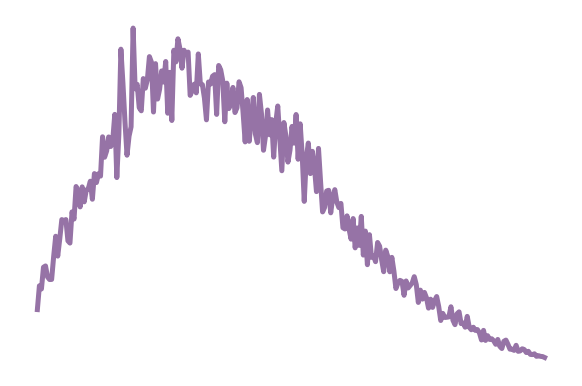

In [20]:
# Clinical-Quality HCP Images Noise Distribution
b = 0.5
color = "#9673A6"

x = np.linspace(rice.ppf(0.01, b), rice.ppf(0.99, b), 250)
# noise = np.random.normal(x.mean(), x.std()/50, size=len(x))
y = rice.pdf(x, b)
y = y * noise
with sns.plotting_context("poster"):
    plt.figure(dpi=120)
    plt.plot(x, y, color=color, lw=3)
    #     plt.ylim(-0.1, 1.5)
    #     plt.plot(-0.1, -0.1, alpha=0)
    plt.xticks([])
    plt.yticks([])
    #     plt.axvline(color='black')
    #     plt.axhline(color='black')
    plt.box(False)

matched_b = b

## HCP & "Clinical" Data Viz

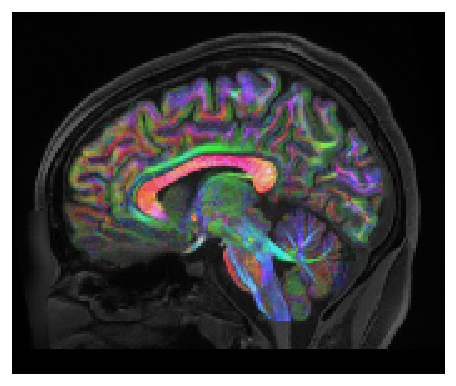

In [134]:
img_filename = "hcp.png"
img = skimage.io.imread(img_filename)
img = img[:, 250:2553]
img = skimage.img_as_float(img)

plt.figure(dpi=120)

plt.imshow(img, interpolation="none")

plt.xticks([])
plt.yticks([])
plt.box(False)

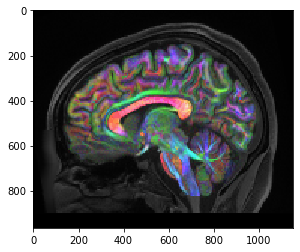

In [53]:
downsample_img = skimage.transform.downscale_local_mean(img, (2, 2, 1))
downsample_img = skimage.exposure.rescale_intensity(downsample_img)

plt.imshow(skimage.exposure.rescale_intensity(downsample_img), interpolation="none")

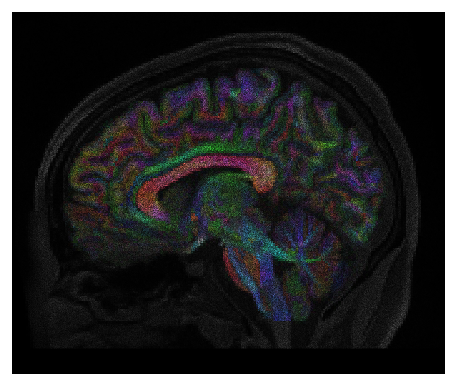

In [147]:
# HCP-Clinical Matched noisy image

matched_noise = scipy.stats.rice.rvs(b=0.2, size=img.shape[:-1])
# matched_noise = matched_noise / (matched_noise.mean() / downsample_img.mean())
matched_noise_img = img * matched_noise[..., None]

downsample_matched_noise_img = skimage.transform.downscale_local_mean(
    matched_noise_img, factors=(2, 2, 1)
)

downsample_matched_noise_img = skimage.exposure.rescale_intensity(downsample_matched_noise_img)

plt.figure(dpi=120)
plt.imshow(downsample_matched_noise_img, interpolation="none")
plt.xticks([])
plt.yticks([])
plt.box(False)

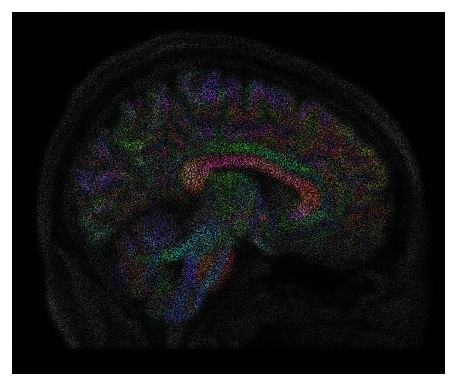

In [160]:
# Clinical Quality Image
downsample_img = skimage.transform.downscale_local_mean(img, (3, 3, 1))
downsample_img = np.fliplr(downsample_img)
downsample_img = skimage.filters.gaussian(downsample_img, sigma=3.5, multichannel=True)
# downsample_img = skimage.exposure.rescale_intensity(downsample_img)
clinic_noise = scipy.stats.rice.rvs(b=clinic_b, size=downsample_img.shape[:-1])

clinic_img = downsample_img * clinic_noise[..., None]

clinic_img = skimage.exposure.rescale_intensity(clinic_img)
plt.figure(dpi=120)
plt.imshow(clinic_img, interpolation="none")
plt.xticks([])
plt.yticks([])
plt.box(False)